In [11]:
import csv
import itertools
import logging
import os
from collections import Counter
from datetime import datetime
from enum import Enum
from functools import reduce
from pathlib import Path
from typing import List, Optional, Union, Any, Callable, Literal

from pydantic.main import IncEx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from anthropic import AnthropicFoundry, beta_tool
from concurrent.futures import ThreadPoolExecutor
import threading

import nltk
import numpy as np
import pandas as pd
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from openai import OpenAI
from pydantic import BaseModel, Field, ConfigDict
from tqdm.autonotebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy import displacy

load_dotenv()

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\alang\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [12]:
# Load datasets as raw CSVs
news_articles_df = pd.read_csv("data/local_news_articles.csv")
press_releases_df = pd.read_csv("data/police_press_releases.csv")

In [13]:
mapping = str.maketrans({
    "ċ": "c",
    "Ċ": "C",
    "ġ": "g",
    "Ġ": "G",
    "ħ": "h",
    "Ħ": "H",
    "ż": "z",
    "Ż": "Z",
    "“": '"',
    "”": '"',
    "‘": "'",
    "’": "'",
    "—": "-",
    "–": "-",
    "…": "...",
})

def clean_articles(df: pd.DataFrame, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.translate(mapping)
    return df

news_articles_df = clean_articles(news_articles_df, ["title", "subtitle", "content"])
press_releases_df = clean_articles(press_releases_df, ["title", "content"])

In [14]:
accident_verbs = {"crash", "collide", "hit", "strike", "overturn"}
accident_nouns = {"car", "vehicle", "truck", "lorry", "pedestrian", "motorcycle", "van", "bus", "bicycle", "traffic"}
accident_type_nouns = {"accident", "crash", "collision"}

subjects = {"driver", "motorcyclist", "motorcycle", "biker", "pedestrian", "cyclist", "rider", "man", "woman", "child"}
injury_verbs = {"hurt", "injure", "wound", "kill", "die", "collide", "crash", "strike", "hit", "rushed"}
injury_adjs = {"injured", "hurt", "wounded", "dead", "killed", "hit"}

transport_verbs = {"rush", "take", "airlift", "transport", "bring", "escort"}

hospital_targets = {"hospital", "clinic", "center", "medical", "emergency", "icu"}

def is_rushed_to_hospital(doc):
    for token in doc:
        # 1️⃣ Check if token is a transport verb in passive form
        if token.lemma_ in transport_verbs and token.dep_ == "ROOT":

            # Look for passive subject: e.g. "motorcyclist" in "was rushed"
            subj = [child for child in token.children if child.dep_ in {"nsubjpass"}]
            if not subj:
                continue

            subj_lemma = subj[0].lemma_
            if subj_lemma not in subjects:
                continue

            for child in token.children:
                if child.lemma_ in hospital_targets:
                    return True

    return False

def refers_to_accident(text: str) -> bool:
    doc = nlp(text)
    has_subj = False
    has_verb = False
    has_vehicle = False
    for token in doc:
        if token.lemma_ in accident_verbs:
            for child in token.children:
                if child.lemma_ in accident_nouns:
                    return True

        # 1️⃣ Active voice: "driver hurt", "motorcyclist crashed"
        if token.lemma_ in injury_verbs:
            for child in token.children:
                if child.lemma_ in subjects and child.dep_ in {"nsubj", "nsubjpass"}:
                    return True

        # 2️⃣ Passive voice: "driver was injured", "motorcyclist was hit"
        if token.lemma_ in injury_adjs:
            for child in token.children:
                if child.dep_ == "nsubj" and child.lemma_ in subjects:
                    return True

        # 3️⃣ Copular constructions: "the motorcyclist is injured"
        # token = adjective ("injured"), child = "motorcyclist"
        if token.lemma_ in injury_adjs:
            for child in token.children:
                if child.dep_ == "nsubj" and child.lemma_ in subjects:
                    return True

        # 4️⃣ Subject → verb pattern: "driver suffered injuries"
        if token.lemma_ in subjects:
            for child in token.children:
                if child.lemma_ in injury_verbs and child.dep_ == "verb":
                    return True

        if token.lemma_ in accident_type_nouns:
            for child in token.children:
                if child.lemma_ in accident_nouns and child.dep_ == "compound":
                    return True

        lemma = token.lemma_.lower()
        if token.dep_ in {"nsubj", "nsubjpass"} and lemma in subjects:
                has_subj = True

        if lemma in (accident_verbs.union(accident_type_nouns, injury_verbs)):
            has_verb = True

        if lemma in accident_nouns:
            has_vehicle = True

    if has_subj and has_verb and has_vehicle:
        return True

    return is_rushed_to_hospital(doc)

non_related_news_article_ids = []

for id, text in news_articles_df[["id", "content"]].values:
    is_accident = refers_to_accident(text)
    if not is_accident:
        non_related_news_article_ids.append(id)

os.makedirs("data/intermediate", exist_ok=True)

if not os.path.exists("data/intermediate/local_news_articles_exclusions.csv"):
    non_related_news_article_df = news_articles_df[news_articles_df["id"].isin(non_related_news_article_ids)]
    non_related_news_article_df.to_csv("data/intermediate/local_news_articles_exclusions.csv", index=False)

non_related_press_release_ids = []
for id, text in press_releases_df[["id", "content"]].values:
    is_accident = refers_to_accident(text)
    if not is_accident:
        non_related_press_release_ids.append(id)

if not os.path.exists("data/intermediate/police_press_releases_exclusions.csv"):
    non_related_press_release_df = press_releases_df[press_releases_df["id"].isin(non_related_press_release_ids)]
    non_related_press_release_df.to_csv("data/intermediate/police_press_releases_exclusions.csv", index=False)

# Police
- 19
- 86
- 109

# Local News
- 4034
- 3989
- 3966
- 3699
- 3563
- 2666
- 1274
- 974
- 685
- 654
- 490008
- 490632
- 491011
- 491334
- 491557
- 492962
- 493044
- 494363
- 496274

What do we define as accident? Does driving without license count? (490267)
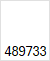

In [15]:
news_articles_excluded_ids = pd.read_csv("data/intermediate/local_news_articles_exclusions.csv")["id"]
news_articles_df = news_articles_df[~news_articles_df["id"].isin(news_articles_excluded_ids)]

press_releases_excluded_ids = pd.read_csv("data/intermediate/police_press_releases_exclusions.csv")["id"]
press_releases_df = press_releases_df[~press_releases_df["id"].isin(press_releases_excluded_ids)]

In [16]:
api_version = "2025-01-01-preview"

endpoint = "https://news-analysis-resource.openai.azure.com/openai/v1/"

token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")

client = OpenAI(
    base_url=endpoint,
    api_key=token_provider,
)

anthropic_client = AnthropicFoundry(
    base_url="https://news-analysis-resource.openai.azure.com/anthropic",
    api_key=os.getenv("AZURE_API_KEY")
)

In [17]:
class Gender(Enum):
    Male = "male"
    Female = "female"
    Other = "other"
    NA = "na"

class Injury(Enum):
    none = "none"
    Slight = "slight"
    Grievous = "grievous"
    Critical = "critical"
    Dead = "dead"

class VehicleType(str, Enum):
    Car = "car"
    Truck = "truck"
    Bus = "bus"
    Motorcycle = "motorcycle"
    Bicycle = "bicycle"
    Van = "van"
    Pedestrian = "pedestrian"

class RoadCondition(str, Enum):
    Dry = "dry"
    Wet = "wet"
    Flood = "flood"
    Oil = "oil"
    Debris = "debris"
    Uneven = "uneven"
    Obstructed = "obstructed"

class HumanFactor(str, Enum):
    Drunk = "drunk"
    Fatigue = "fatigue"
    Speeding = "speeding"

class Infrastructure(str, Enum):
    Intersection = "intersection"
    Roundabout = "roundabout"
    Junction = "junction"
    Highway = "highway"
    Residential_Road = "residential_road"
    Bridge = "bridge"
    Tunnel = "tunnel"
    Crosswalk = "crosswalk"

class AccidentRecord(BaseModel, extra="forbid"):
    model_config = ConfigDict(use_enum_values=True)

    id: int = Field(description="""The id of the accident. This is the same as the given CSV.""")
    date_of_accident: Optional[datetime] = Field(description="""The date and time that the accident occurred""")
    num_people_involved: int = Field(description="""The number of people involved in the accident""")
    num_drivers: int = Field(description="""The number of drivers involved in the accident""")
    driver_ages: List[Optional[int]] = Field(description="""The ages of the drivers involved. The length of this list must be the same as `num_drivers`. Leave as None if not available""")
    driver_genders: List[Union[Gender, str]] = Field(description="""The genders of the drivers involved in the accident. The length of this list must be the same as `num_drivers`""")
    injury_severities: List[Union[Injury, str]] = Field(description="""The severity of injuries of each person. The length of this list must be the same as `num_people_involved`""")
    # accident_type: Literal["head-on", "rear-end", "multi-vehicle", "other"]
    # """The type of accident"""
    num_vehicles_involved: int = Field(description="""The number of vehicles involved in the accident""")
    vehicle_types: List[Union[VehicleType, str]] = Field(description="""The types of vehicles involved in the accident. The length of this list must be the same as `num_vehicles_involved`""")
    road_conditions: List[Union[RoadCondition, str]] = Field(description="""The condition of the road that the accident occurred""")
    human_factors: List[Union[HumanFactor, str]] = Field(description="""The human factors which caused the accident to occur""")
    infrastructure: List[Union[Infrastructure, str]] = Field(description="""The infrastructure where the accident occurred""")
    road_name: Optional[str] = Field(description="""The name of the road that the accident occurred""")
    locality: Optional[str] = Field(description="""The name of the locality that the accident occurred""")
    valid_accident: bool = Field(description="""Whether or not the record refers to a vehicle accident""")

    def model_dump(
        self,
        *,
        mode: Literal['json', 'python'] | str = 'python',
        include: IncEx | None = None,
        exclude: IncEx | None = None,
        context: Any | None = None,
        by_alias: bool | None = None,
        exclude_unset: bool = False,
        exclude_defaults: bool = False,
        exclude_none: bool = False,
        exclude_computed_fields: bool = False,
        round_trip: bool = False,
        warnings: bool | Literal['none', 'warn', 'error'] = True,
        fallback: Callable[[Any], Any] | None = None,
        serialize_as_any: bool = False,
    ) -> dict[str, Any]:
        data = super().model_dump(mode=mode, include=include, exclude=exclude, context=context,
                                  by_alias=by_alias, exclude_unset=exclude_unset, exclude_defaults=exclude_defaults,
                                  exclude_none=exclude_none, exclude_computed_fields=exclude_computed_fields,
                                  round_trip=round_trip, warnings=warnings, fallback=fallback,
                                  serialize_as_any=serialize_as_any)
        data.pop("valid_accident")
        return data

    @staticmethod
    def empty(id: int):
        return AccidentRecord(
            id=id,
            date_of_accident=None,
            num_people_involved=0,
            num_drivers=0,
            driver_ages=[],
            driver_genders=[],
            injury_severities=[],
            num_vehicles_involved=0,
            vehicle_types=[],
            road_conditions=[],
            human_factors=[],
            infrastructure=[],
            road_name=None,
            locality=None,
            valid_accident=False
        )


class Accidents(BaseModel, extra="forbid"):
    accidents: List[AccidentRecord]
    """A list of all accidents"""

    def to_dict_list(self):
        return [a.model_dump() for a in self.accidents if a.valid_accident]

In [18]:
models = [("gpt-5-mini", 50), ("grok-4-fast-non-reasoning", 50), ("DeepSeek-R1-0528", 20)]

system_msg = lambda dataset_type: f"""
You are given a number of rows of a semi-structured CSV dataset of {dataset_type} about car accidents.
Your task is to extract information from the content of each record and return a list of accidents with their corresponding data.
Make sure that the number of elements in the list in the returned JSON match the number of rows in the given CSV.

IMPORTANT: You MUST return the data by calling the `set_accidents` function.
VERY IMPORTANT: YOU MUST RETURN THE SAME NUMBER OF ELEMENTS AS ROWS GIVEN IN THE CSV.
If you cannot find a value for a record or field, return a default value:
- int: 0
- str: ""
- Optional[...]: None
- List: []

The ID MUST be copied from the given CSV.
If a record is not of a vehicle accident (i.e. of other news), set `valid_accident` to False. Otherwise, set it to True.
If you cannot fill in any values, set `valid_accident` to False. DO NOT RETURN A FULLY EMPTY ROW WITH `valid_accident` as True.

DO NOT CREATE ANY INFORMATION NOT PRESENT IN THE CSV.
DO NOT include any introduction such as "Here is the answer..." or conclusion, only the JSON.
"""

csv_prompt = lambda dataset_csv, start_rows, end_rows, total_rows, extra=None: f"""
{f"IMPORTANT: {extra}" if extra else ""}

Make sure to return EXACTLY {end_rows - start_rows} rows.

Accident CSV Data ({start_rows}-{end_rows}/{total_rows} rows):

{dataset_csv}
"""

datasets = [
    ("local news articles", news_articles_df),
    ("police press releases", press_releases_df),
]


In [19]:
data_dir = Path("data/llm_processed")
os.makedirs(data_dir, exist_ok=True)

result_function = {
    "type": "function",
    "function": {
        "name": "set_accidents",
        "description": "Set the accident data obtained from the given CSV",
        "parameters": Accidents.model_json_schema()
    }
}

tools = [result_function]

def to_snake_case(text: str):
    return text.lower().replace(" ", "_").replace("-", "_")

In [20]:
tqdm.set_lock(threading.RLock())

def process_model(model, num_rows_per_request, dataset_df: pd.DataFrame, system_prompt):
    save_path = data_dir / f"{to_snake_case(dataset_type)}_{to_snake_case(model)}.csv"
    if not os.path.exists(save_path):
        open(save_path, "w").close()

    with tqdm(range(0, len(dataset_df.index), num_rows_per_request), desc=f"Querying {model}", total=len(dataset_df.index), unit=" rows") as pbar:
        i = 0
        extra = None
        while i < len(dataset_df.index):
            try:
                start = i
                end = min(i + num_rows_per_request, len(dataset_df.index))

                df_section: pd.DataFrame = dataset_df.iloc[start:end]
                df_section_csv = df_section.to_csv(index=False)

                messages = [
                    {
                        "role": "system",
                        "content": system_prompt,
                    },
                    {
                        "role": "user",
                        "content": csv_prompt(df_section_csv, start + 1, end + 1, len(dataset_df.index), extra),
                    }
                ]

                response = client.chat.completions.create(
                    model=model,
                    tools=tools,
                    messages=messages,
                )

                result: Accidents = Accidents.model_validate_json(response.choices[0].message.tool_calls[0].function.arguments)
                for accident in result.accidents:
                    if accident.id not in dataset_df["id"].values:
                        raise ValueError(f"ID {accident.id} not in dataset {dataset_type}")

                if len(result.accidents) != end - start:
                    cur_ids = set(accident.id for accident in result.accidents)
                    df_ids = set(df_section["id"])
                    missing_ids = [str(id) for id in df_ids - cur_ids]
                    extra = f"Make sure to include ids: {", ".join(missing_ids)}"
                    raise ValueError(f"Received a different number of rows (expected: {end - start}, received: {len(result.accidents)})")

                result_list = result.to_dict_list()
                with open(save_path, "a", newline="", encoding="utf-8") as f:
                    writer = csv.DictWriter(f, result_list[0].keys())
                    if os.path.getsize(save_path) == 0:
                        writer.writeheader()

                    writer.writerows(result_list)

                pbar.update(end - start)
                i += num_rows_per_request
                extra = None
            except Exception as e:
                logging.warning(f"Failed to query {model}: {e}")

for dataset_type, dataset_df in datasets:
    system_prompt = system_msg(dataset_type)
    with ThreadPoolExecutor(max_workers=len(models)) as executor:
        futures = [
            executor.submit(
                process_model,
                model,
                num_rows_per_request,
                dataset_df,
                system_prompt
            )
            for model, num_rows_per_request in models
        ]

        # Optional: wait for all to complete
        for f in futures:
            f.result()


Querying grok-4-fast-non-reasoning:   0%|          | 0/252 [00:00<?, ? rows/s]

Querying gpt-5-mini:   0%|          | 0/252 [00:00<?, ? rows/s]

Querying DeepSeek-R1-0528:   0%|          | 0/252 [00:00<?, ? rows/s]

accidents.0.date_of_accident
  Input should be a valid datetime or date, unexpected extra characters at the end of the input [type=datetime_from_date_parsing, input_value='2025-10-09 15:07:23.444052+00', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/datetime_from_date_parsing
accidents.1.date_of_accident
  Input should be a valid datetime or date, unexpected extra characters at the end of the input [type=datetime_from_date_parsing, input_value='2025-10-10 12:22:30.72069+00', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/datetime_from_date_parsing


Querying gpt-5-mini:   0%|          | 0/111 [00:00<?, ? rows/s]

Querying grok-4-fast-non-reasoning:   0%|          | 0/111 [00:00<?, ? rows/s]

Querying DeepSeek-R1-0528:   0%|          | 0/111 [00:00<?, ? rows/s]

In [21]:
import ast


# Validate/Clean CSVs
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    replace_vals = {
        "unknown": "na"
    }

    def replace_values(iter):
        return [replace_vals[v] if v in replace_vals else v for v in iter]

    df["date_of_accident"] = pd.to_datetime(df["date_of_accident"], format="mixed", dayfirst=True, utc=True)
    df["driver_ages"] = df["driver_ages"].apply(lambda x: replace_values(ast.literal_eval(x)))
    df["driver_genders"] = df["driver_genders"].apply(lambda x: replace_values(ast.literal_eval(x)))
    df["injury_severities"] = df["injury_severities"].apply(lambda x: replace_values(ast.literal_eval(x)))
    df["vehicle_types"] = df["vehicle_types"].apply(lambda x: replace_values(ast.literal_eval(x)))
    df["road_conditions"] = df["road_conditions"].apply(lambda x: replace_values(sorted(ast.literal_eval(x))))
    df["human_factors"] = df["human_factors"].apply(lambda x: replace_values(sorted(ast.literal_eval(x))))
    df["infrastructure"] = df["infrastructure"].apply(lambda x: replace_values(sorted(ast.literal_eval(x))))

    return df

csv_paths = [
    data_dir / f"{to_snake_case(dataset_type)}_{to_snake_case(model)}.csv" for (dataset_type, _), (model, _) in itertools.product(datasets, models)
]

dfs = {}
for dataset_type, _ in datasets:
    dfs[dataset_type] = {}
    for model, _ in models:
        csv_path = data_dir / f"{to_snake_case(dataset_type)}_{to_snake_case(model)}.csv"
        dfs[dataset_type][model] = clean_df(pd.read_csv(csv_path))

In [22]:
def compute_final_and_confidence(values: np.ndarray, validate_func: Optional[Callable[[Any], bool]]):
    total = len(values)
    values = [v for v in values if pd.notna(v) and (validate_func is None or validate_func(v))]

    if len(values) == 0:
        return np.nan, 0

    counts = Counter(values)
    final_value, freq = counts.most_common(1)[0]

    confidence = freq / total

    return final_value, confidence

def compute_list_final_and_confidence(values: np.ndarray[list], preserve_order: bool, validate_func: Optional[Callable[[Any], bool]]):
    total = len(values)
    values = [v for v in values if isinstance(v, list)]
    if len(values) == 0:
        return np.nan, 0

    if not preserve_order:
        values = [v for vals in values for v in set(vals)]
        counts = Counter(values)
        final_values, freqs = list(counts.keys()), list(counts.values())
        confidences = [freq / total for freq in freqs]
        return final_values, confidences
    else:
        max_index = max(len(v) for v in values)
        counters = [Counter([vals[i] for vals in values if len(vals) > i]) for i in range(max_index)]
        final_values = [count.most_common(1)[0][0] for count in counters]
        confidences = [count.most_common(1)[0][1] / total for count in counters]
        return final_values, confidences

def combine_field(field_name: str, datasets: dict[str, pd.DataFrame], confidence_func: Callable[[list, Optional[Callable[[Any], bool]]], tuple[Any, Any]], validate_func: Optional[Callable[[Any], bool]] = None) -> pd.DataFrame:
    renamed_dfs = []
    data_cols = []
    for df_name, df in datasets.items():
        sub: pd.DataFrame = df[["id", field_name]].copy()
        sub = sub.rename(columns={field_name: f"{field_name}_{df_name}"})
        data_cols.append(f"{field_name}_{df_name}")
        renamed_dfs.append(sub)

    merged = reduce(lambda left, right: pd.merge(left, right, on="id", how="outer"), renamed_dfs)

    extra_rows = []
    for _, row in merged.iterrows():
        values = row[data_cols].values

        final_value, confidence = confidence_func(values, validate_func)
        if isinstance(confidence, list):
            confidence = [f"{c:.2f}" for c in confidence]
        else:
            confidence = f"{confidence:.2f}"

        extra_rows.append({
            f"{field_name}_final_value": final_value,
            f"{field_name}_confidence": confidence,
        })

    return pd.concat([merged, pd.DataFrame(extra_rows)], axis=1)

gt_0 = lambda v: v > 0

# TODO: Add field specific comparisons
data_cols = [
    ("date_of_accident", compute_final_and_confidence, None),
    ("num_people_involved", compute_final_and_confidence, gt_0),
    ("num_drivers", compute_final_and_confidence, gt_0),
    ("driver_ages", lambda x, val_func: compute_list_final_and_confidence(x, True, val_func), gt_0),
    ("driver_genders", lambda x, val_func: compute_list_final_and_confidence(x, True, val_func), None),
    ("injury_severities", lambda x, val_func: compute_list_final_and_confidence(x, True, val_func), None),
    ("num_vehicles_involved", compute_final_and_confidence, gt_0),
    ("vehicle_types", lambda x, val_func: compute_list_final_and_confidence(x, True, val_func), None),
    ("road_conditions", lambda x, val_func: compute_list_final_and_confidence(x, False, val_func), None),
    ("human_factors", lambda x, val_func: compute_list_final_and_confidence(x, False, val_func), None),
    ("infrastructure", lambda x, val_func: compute_list_final_and_confidence(x, False, val_func), None),
    ("road_name", compute_final_and_confidence, None),
    ("locality", compute_final_and_confidence, None),
]

os.makedirs("data/merged", exist_ok=True)

for dataset_type, dataset_df in datasets:
    dataset_dfs = dfs[dataset_type]
    combined_fields = [combine_field(field_name, dataset_dfs, compute_func, validate_func).set_index("id") for field_name, compute_func, validate_func in data_cols]
    merged = pd.concat(combined_fields, axis=1).reset_index()
    dataset_ids = set(dataset_df["id"])
    merged_ids = set(merged["id"])
    extra_ids = merged_ids - dataset_ids

    if len(extra_ids) > 0:
        merged = merged[~merged["id"].isin(extra_ids)]

    merged.to_csv(Path("data/merged") / f"{to_snake_case(dataset_type)}_combined.csv", index=False)


# Review merged
- Find empty rows and check if they are relevant
- Check non-confident values and manually set the final value

# Ambiguities
- 751: Date - Only "night" was mentioned, no specific time. Set time to 8pm
- 1274: Date - Only morning was given and that traffic subsided by 11:15am. Set time to 8am.
- 2101: Date - No time mentioned. Leaving time at midnight
- 2201: Date - No time mentioned. Leaving time at midnight